In [1]:
import os
import pandas as pd
import numpy as np
import sentencepiece as sp

In [2]:
def iter_pipeline(text):
    for line in text:
        line = line.rstrip()
        yield line

In [3]:
def train_sp_model(path_to_save, text, vocab_size):
    sp.SentencePieceTrainer.train(
        sentence_iterator=iter_pipeline(text),
        model_prefix=path_to_save,
        vocab_size=vocab_size,
        character_coverage=1.0,
        model_type="bpe",
    )

In [4]:
np.random.seed(12237)

In [5]:
binary_score_converter = {"Yes": 1,
                          "No": 0}

In [9]:
def train_validate_test_split(df, train_percent=0.7, validate_percent=0.2, seed=None):
    perm = np.random.permutation(range(len(df)))
    m = len(df.index)
    train_end = int(train_percent * m)
    print(train_end)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [10]:
def preprocess_dataset(df, test=False):
    df["Ligand_len"] = df["Ligand SMILES"].apply(lambda x: len(x))
    df["Target_Chain_len"] = df["BindingDB Target Chain Sequence"].apply(lambda x: len(x))
    filtered_data = df[df.Target_Chain_len < 2048]
    if not test:
        filtered_data = filtered_data[filtered_data.ligand_split == "train"]
    filtered_data["logIC50"] = np.log10(filtered_data["IC50_nM_mean"] + 1e-6)
    filtered_data["IAM"] = filtered_data["Is_Above_Median"].apply(lambda x: binary_score_converter[x])
    return filtered_data

In [12]:
data = pd.read_csv("../csv_dataset/train_ligand.csv")

In [13]:
filtered_data = preprocess_dataset(data)

In [14]:
filtered_data.iloc[0]["Ligand SMILES"]

'B.CP(c1ccccc1)c1ccc(O)cc1'

In [15]:
filtered_data.iloc[0]["BindingDB Target Chain Sequence"]

'MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAMTFYSPAVMNYSIPSNVTNLEGGPGRQTTSPNVLWPTPGHLSPLVVHRQLSHLYAEPQKSPWCEARSLEHTLPVNRETLKRKVSGNRCASPVTGPGSKRDAHFCAVCSDYASGYHYGVWSCEGCKAFFKRSIQGHNDYICPATNQCTIDKNRRKSCQACRLRKCYEVGMVKCGSRRERCGYRLVRRQRSADEQLHCAGKAKRSGGHAPRVRELLLDALSPEQLVLTLLEAEPPHVLISRPSAPFTEASMMMSLTKLADKELVHMISWAKKIPGFVELSLFDQVRLLESCWMEVLMMGLMWRSIDHPGKLIFAPDLVLDRDEGKCVEGILEIFDMLLATTSRFRELKLQHKEYLCVKAMILLNSSMYPLVTATQDADSSRKLAHLLNAVTDALVWVIAKSGISSQQQSMRLANLLMLLSHVRHASNKGMEHLLNMKCKNVVPVYDLLLEMLNAHVLRGCKSSITGSECSPAEDSKSKEGSQNPQSQ'

In [16]:
data

,Protein_Name,Unnamed: 1,Ligand SMILES,BindingDB Target Chain Sequence,IC50_nM_mean,Is_Above_Median,is_over_500,IC50_M,pIC50,protein_split,ligand_split,final_split,Ligand_len,Target_Chain_len
0,protein_0,0,B.CP(c1ccccc1)c1ccc(O)cc1,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,2500.0,Yes,Yes,0.000003,5.602060,train,train,train,25,530
1,protein_1,1,B.CP(c1ccccc1)c1ccc(O)cc1,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,9800.0,Yes,Yes,0.000010,5.008774,train,train,train,25,595
2,protein_0,2,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,2000.0,Yes,Yes,0.000002,5.698970,train,train,train,32,530
3,protein_1,3,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,12000.0,Yes,Yes,0.000012,4.920819,train,train,train,32,595
4,protein_2,4,BB(B)B(B)B(B(B)B)B1CC1CNC(=O)[C@@H]1C[C@@H](F)...,MHSWERLAVLVLLGAAACAAPPRGRILGGREAEAHARPYMASVQLN...,1000.0,Yes,Yes,0.000001,6.000000,train,train,train,90,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245196,protein_1053,1549028,c1sc(nc1-c1cnc(nc1)-c1ccccc1)-c1ccccc1,MPNYKLTYFNMRGRAEIIRYIFAYLDIQYEDHRIEQADWPEIKSTL...,20000.0,Yes,Yes,0.000020,4.698970,train,train,train,38,199
1245197,protein_283,1549030,c1sc(nc1-c1nc2ccccc2s1)-c1ncccn1,MVLEMLNPIHYNITSIVPEAMPAATMPVLLLTGLFLLVWNYEGTSS...,1000.0,Yes,Yes,0.000001,6.000000,train,train,train,32,503
1245198,protein_846,1549031,c1sc2ncn3cnnc3c2c1-c1ccccc1,MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWESPAQNTAHLDQFER...,19010.0,Yes,Yes,0.000019,4.721018,train,train,train,27,351
1245199,protein_277,1549032,c1scc2c1ncc1cnccc21,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,15794.0,Yes,Yes,0.000016,4.801508,test,train,train,19,1441


In [19]:
filtered_data.iloc[0]

Protein_Name                                                               protein_0
Unnamed: 1                                                                         0
Ligand SMILES                                              B.CP(c1ccccc1)c1ccc(O)cc1
BindingDB Target Chain Sequence    MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...
IC50_nM_mean                                                                  2500.0
Is_Above_Median                                                                  Yes
is_over_500                                                                      Yes
IC50_M                                                                      0.000003
pIC50                                                                        5.60206
protein_split                                                                  train
ligand_split                                                                   train
final_split                                                      

In [ ]:
#filtered_data = filtered_data.sample(frac=0.7, random_state=1337)

In [18]:
len(filtered_data)

1210017

In [20]:
train, val, _ = train_validate_test_split(filtered_data, 0.8, 0.2)

968013


In [21]:
test = preprocess_dataset(pd.read_csv("../csv_dataset/test_ligand.csv"), test=True)

/tmp/ipykernel_173870/1672692349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["logIC50"] = np.log10(filtered_data["IC50_nM_mean"] + 1e-6)
/tmp/ipykernel_173870/1672692349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["IAM"] = filtered_data["Is_Above_Median"].apply(lambda x: binary_score_converter[x])


In [14]:
test

,Protein_Name,Unnamed: 1,Ligand SMILES,BindingDB Target Chain Sequence,IC50_nM_mean,Is_Above_Median,is_over_500,IC50_M,pIC50,protein_split,ligand_split,final_split,Ligand_len,Target_Chain_len,logIC50,IAM
0,protein_13,43,Br.Br.O=C1N(CCNCCCCNCCN2C(=O)c3cccc4cccc(C2=O)...,MTASPRAPHQEHVLGEPTLEGLAHYIREKNVRRILVLVGAGASVAA...,5700.0,Yes,Yes,5.700000e-06,5.244125,test,test,test,70,373,3.755875,1
1,protein_62,259,Br.Oc1ccc2C(CCc2c1O)C1=NCCN1,MNPDLDTGHNTSAPAHWGELKDDNFTGPNQTSSNSTLPQLDVTRAI...,1570.0,Yes,Yes,1.570000e-06,5.804100,test,test,test,28,515,3.195900,1
2,protein_67,270,BrC(=C)COc1noc2CC[NH2+]Cc12,MNNSTNSSNNGLAITSPYKTFEVVFIVLVAGSLSLVTIIGNILVMV...,13000.0,Yes,Yes,1.300000e-05,4.886057,test,test,test,27,466,4.113943,1
3,protein_68,271,BrC(=C)COc1noc2CC[NH2+]Cc12,MTLHNNSTTSPLFPNISSSWIHSPSDAGLPPGTVTHFGSYNVSRAA...,22000.0,Yes,Yes,2.200000e-05,4.657577,test,test,test,27,590,4.342423,1
4,protein_87,312,BrC1=C[C@]23C[C@H](SC2=CC1=O)N=C1C3C2=NCCc3c[n...,MKKWTNRLMTIAGVVLILVAAYLFAKPHIDNYLHDKDKDEKIEQYD...,131700.0,Yes,Yes,1.317000e-04,3.880414,test,test,test,58,206,5.119586,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53021,protein_554,1548883,c1nc2ccc(cc2[nH]1)-n1cnc2cnc3cnc(cc3c12)-c1cccnc1,MEYMSTGSDNKEEIDLLIKHLNVSDVIDIMENLYASEEPAVYEPSL...,670.0,Yes,Yes,6.700000e-07,6.173925,test,test,test,49,467,2.826075,1
53022,protein_554,1548886,c1nc2ccc(cc2[nH]1)-n1cnc2cnc3cnc(cc3c12)-c1cnsc1,MEYMSTGSDNKEEIDLLIKHLNVSDVIDIMENLYASEEPAVYEPSL...,160.0,No,No,1.600000e-07,6.795880,test,test,test,48,467,2.204120,0
53023,protein_286,1548892,c1nc2cccc(-c3ccccc3)n2n1,MDSPCQPQPLSQALPQLPGSSSEPLEPEPGRARMGVESYLPCPLLP...,30000.0,Yes,Yes,3.000000e-05,4.522879,test,test,test,24,407,4.477121,1
53024,protein_625,1548905,c1nc2ccccc2n1-c1ccc(cc1)-c1ccnc(n1)-c1ccccn1,MSSFEGQMAEYPTISIDRFDRENLRARAYFLSHCHKDHMKGLRAPT...,4650.0,Yes,Yes,4.650000e-06,5.332547,test,test,test,44,692,3.667453,1


In [22]:
combined = pd.concat([train, val, test])

In [23]:
mean_ = combined["logIC50"].mean()
std_ = combined["logIC50"].std()
for df, df_name in zip([train, val, test], ["train.csv", "val.csv", "test.csv"]):
    df["logIC50_scaled"] = (df["logIC50"] - mean_) / std_
    df_to_save = df[["Ligand SMILES", "BindingDB Target Chain Sequence", "IAM", "logIC50_scaled"]]
    df_to_save.rename(columns={"Ligand SMILES": "Ligand",
                                      "BindingDB Target Chain Sequence": "Target_Chain",
                                      },
                            inplace=True)
    save_dir = f"../dataset/filtered_ligand_full_z_{round(mean_, 3)}_{round(std_, 3)}"
    os.makedirs(save_dir, exist_ok=True)
    df_to_save.to_csv(os.path.join(save_dir, df_name), header=True, index=False)

/tmp/ipykernel_173870/537732043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logIC50_scaled"] = (df["logIC50"] - mean_) / std_
/tmp/ipykernel_173870/537732043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save.rename(columns={"Ligand SMILES": "Ligand",
/tmp/ipykernel_173870/537732043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [18]:
pd.read_csv("../dataset/filtered_binding_finalm_180k_12.52_-6.0/train.csv")

,Ligand,Target_Chain,IAM,logIC50_scaled
0,CNC(=O)NC1CCC(CS(=O)(=O)NNC(=O)c2cc(cc(Cl)c2F)...,MVKLANPLYTEWILEAIKKVKKQKQRPSEERICNAVSSSHGLDRKT...,1,0.539957
1,C[C@@H]1Oc2nc(c(F)c3nc(OC[C@@]45CCCN4C[C@H](F)...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,0,0.314513
2,Nc1c2[C@@H](O)CC[C@@H](O)c2nc2ccccc12,MRPPWYPLHTPSLASPLLFLLLSLLGGGARAEGREDPQLLVRVRGG...,1,0.521747
3,CC(=O)N[C@@H]1[C@@H](O)[C@@H](F)[C@@](F)(O[C@H...,MLPSTIQTLTLFLTSGGVLLSLYVSASLSYLLYSDILLKFSPTEIT...,1,0.520625
4,CCc1nc2cc3CCN(CCCCSc4nnc(-c5cccc6nc(C)ccc56)n4...,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,1,0.496760
...,...,...,...,...
145197,CCCc1nc2c(C)cc(cc2n1Cc1ccc(cc1)-c1ccccc1-c1nnn...,MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGN...,0,0.361715
145198,Cc1c(O)c(=O)ccn1CCNC(=O)c1cc2cc(OCc3ccccc3)ccc...,MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTL...,0,0.431965
145199,CC(C)C[C@H]1NC(=O)[C@H](CC(C(O)=O)C(O)=O)NC(=O...,MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDG...,1,0.469800
145200,Cc1nc([C@@H]2O[C@H](CO)[C@H](O)[C@@H]([C@H]2O)...,MADSFSLNDALAGSGNPNPQGYPGAWGNQPGAGGYPGAAYPGAYPG...,1,0.494674


In [16]:
mean_ = combined["logIC50"].mean()
std_ = combined["logIC50"].std()
for df, df_name in zip([train, val, test], ["train.csv", "val.csv", "test.csv"]):
    df["logIC50_scaled"] = (df["logIC50"] - mean_) / std_
    df_to_save = df[["Ligand SMILES", "BindingDB Target Chain Sequence", "IAM", "logIC50_scaled"]]
    df_to_save.rename(columns={"Ligand SMILES": "Ligand",
                                      "BindingDB Target Chain Sequence": "Target_Chain",
                                      },
                            inplace=True)
    save_dir = f"../dataset/filtered_binding_finalm_100k_std_{round(mean_, 4)}_{round(std_, 4)}"
    os.makedirs(save_dir, exist_ok=True)
    df_to_save.to_csv(os.path.join(save_dir, df_name), header=True, index=False)

/tmp/ipykernel_86371/822479660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logIC50_scaled"] = (df["logIC50"] - mean_) / std_
/tmp/ipykernel_86371/822479660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save.rename(columns={"Ligand SMILES": "Ligand",
/tmp/ipykernel_86371/822479660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [48]:
train

,Protein_Name,Unnamed: 1,Ligand SMILES,BindingDB Target Chain Sequence,IC50_nM_mean,Is_Above_Median,is_over_500,IC50_M,pIC50,protein_split,ligand_split,final_split,Ligand_len,Target_Chain_len,logIC50,IAM,logIC50_scaled
523405,protein_613,541241,CNC(=O)NC1CCC(CS(=O)(=O)NNC(=O)c2cc(cc(Cl)c2F)...,MVKLANPLYTEWILEAIKKVKKQKQRPSEERICNAVSSSHGLDRKT...,10000.000,Yes,Yes,1.000000e-05,5.000000,train,train,train,60,2004,4.000000,1,0.539957
862970,protein_545,893686,C[C@@H]1Oc2nc(c(F)c3nc(OC[C@@]45CCCN4C[C@H](F)...,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,0.668,No,No,6.680000e-10,9.175224,train,train,train,108,189,-0.175223,0,0.314513
1283636,protein_124,1329926,Nc1c2[C@@H](O)CC[C@@H](O)c2nc2ccccc12,MRPPWYPLHTPSLASPLLFLLLSLLGGGARAEGREDPQLLVRVRGG...,4600.000,Yes,Yes,4.600000e-06,5.337242,train,train,train,37,614,3.662758,1,0.521747
36598,protein_2337,37790,CC(=O)N[C@@H]1[C@@H](O)[C@@H](F)[C@@](F)(O[C@H...,MLPSTIQTLTLFLTSGGVLLSLYVSASLSYLLYSDILLKFSPTEIT...,4385.000,Yes,Yes,4.385000e-06,5.358030,test,train,train,66,466,3.641970,1,0.520625
408675,protein_250,422545,CCc1nc2cc3CCN(CCCCSc4nnc(-c5cccc6nc(C)ccc56)n4...,MPVRRGHVAPQNTFLDTIIRKFEGQSRKFIIANARVENCAVIYCND...,1584.890,Yes,Yes,1.584890e-06,5.800001,train,train,train,60,1159,3.199999,1,0.496760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291474,protein_522,300719,CCCc1nc2c(C)cc(cc2n1Cc1ccc(cc1)-c1ccccc1-c1nnn...,MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGN...,5.000,No,No,5.000000e-09,8.301030,train,train,train,76,359,0.698970,0,0.361715
926226,protein_24,959121,Cc1c(O)c(=O)ccn1CCNC(=O)c1cc2cc(OCc3ccccc3)ccc...,MSNKCDVVVVGGGISGMAAAKLLHDSGLNVVVLEARDRVGGRTYTL...,100.000,No,No,1.000000e-07,7.000000,train,train,train,52,520,2.000000,0,0.431965
111658,protein_2194,115091,CC(C)C[C@H]1NC(=O)[C@H](CC(C(O)=O)C(O)=O)NC(=O...,MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDG...,502.000,Yes,Yes,5.020000e-07,6.299296,train,train,train,213,217,2.700704,1,0.469800
1040027,protein_4900,1077442,Cc1nc([C@@H]2O[C@H](CO)[C@H](O)[C@@H]([C@H]2O)...,MADSFSLNDALAGSGNPNPQGYPGAWGNQPGAGGYPGAAYPGAYPG...,1450.000,Yes,Yes,1.450000e-06,5.838632,train,train,train,93,264,3.161368,1,0.494674


In [70]:
train_sp_model("test.model", train["BindingDB Target Chain Sequence"], 8196)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: test.model
  model_type: BPE
  vocab_size: 8196
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 

In [71]:
spp_f = sp.SentencePieceProcessor(model_file="test.model.model")

In [72]:
train["tc_len"] = train["BindingDB Target Chain Sequence"].apply(lambda x: len(spp_f.encode(x)))

/tmp/ipykernel_86371/814554684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["tc_len"] = train["BindingDB Target Chain Sequence"].apply(lambda x: len(spp_f.encode(x)))


In [73]:
train["tc_len"]

523405     832
862970      16
1283636    204
36598      211
408675     105
          ... 
291474     144
926226     168
111658      93
1040027    115
1157680    177
Name: tc_len, Length: 145202, dtype: int64

<Axes: >

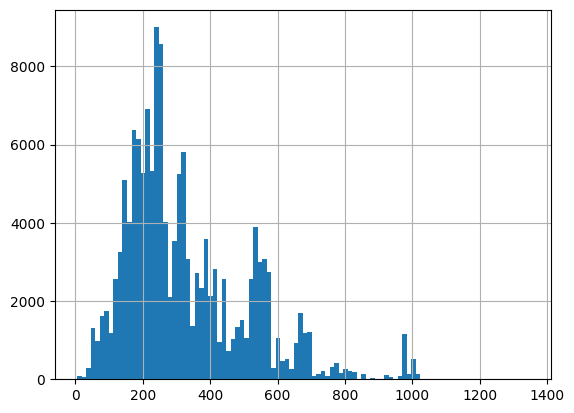

In [68]:
train["tc_len"].hist(bins=100)

In [60]:
spp_f.encode_as_pieces("MVKL")

['▁', 'M', 'V', 'K', 'L']

In [58]:
spp_f.encode("MVKL")

[95, 92, 80, 82, 75]

In [55]:
train["tc_len"]

523405     1480
862970      145
1283636     455
36598       360
408675      852
           ... 
291474      280
926226      396
111658      166
1040027     208
1157680     322
Name: tc_len, Length: 145202, dtype: int64

In [35]:
df = pd.read_json("../dataset/filtered_binding_finalm_180k_12.52_-6.0/processed_data/train.json")

In [40]:
df

,Target_Chain_encoded,Ligand_encoded,logIC50_scaled,tc_len
0,"[95, 92, 79, 22, 78, 89, 17, 90, 49, 94, 13, 7...","[135, 5, 203, 201, 10, 202, 15, 200, 87, 5, 20...",0.539957,1472
1,"[95, 92, 49, 90, 22, 18, 79, 80, 78, 20, 79, 8...","[12, 209, 199, 13, 211, 24, 18, 204, 8, 200, 1...",0.314513,144
2,"[95, 92, 83, 9, 94, 90, 17, 91, 84, 81, 8, 29,...","[94, 202, 198, 54, 199, 13, 211, 11, 203, 201,...",0.521747,460
3,"[95, 64, 27, 84, 85, 87, 12, 12, 21, 33, 20, 7...","[23, 5, 203, 201, 205, 209, 199, 13, 211, 136,...",0.520625,358
4,"[95, 92, 43, 32, 80, 91, 79, 78, 73, 89, 84, 2...","[123, 202, 8, 204, 3, 213, 29, 200, 35, 110, 2...",0.496760,853
...,...,...,...,...
145197,"[95, 92, 13, 89, 4, 49, 54, 85, 82, 71, 87, 86...","[92, 198, 202, 8, 204, 198, 200, 199, 201, 3, ...",0.361715,274
145198,"[95, 92, 76, 89, 82, 93, 86, 18, 18, 20, 80, 3...","[40, 202, 198, 200, 203, 201, 198, 5, 203, 201...",0.431965,397
145199,"[95, 92, 77, 56, 78, 82, 90, 65, 82, 66, 78, 8...","[23, 200, 199, 201, 199, 209, 199, 208, 211, 2...",0.469800,170
145200,"[95, 92, 78, 39, 88, 8, 89, 86, 6, 78, 24, 80,...","[40, 202, 8, 59, 199, 13, 211, 44, 203, 209, 1...",0.494674,208


In [41]:
df["tc_len"] = df["Target_Chain_encoded"].apply(lambda x: len(x))
df["lig_len"] = df["Ligand_encoded"].apply(lambda x: len(x))

<Axes: >

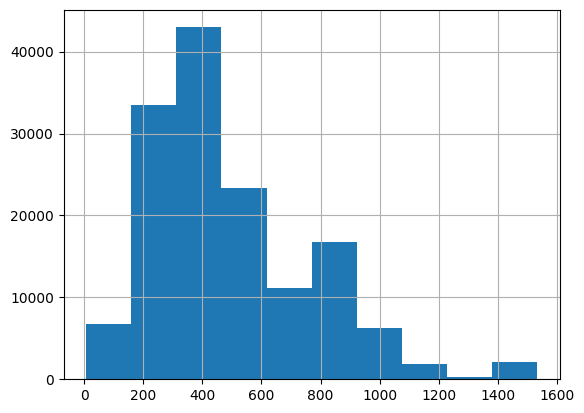

In [39]:
df["tc_len"].hist()

<Axes: >

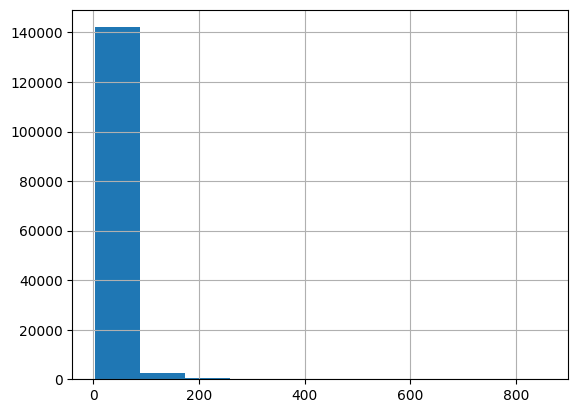

In [43]:
df["lig_len"].hist()

In [117]:
def my_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    f_seq = [item[0] for item in batch]
    f_seq = torch.nn.utils.rnn.pad_sequence(f_seq, batch_first=True)

    s_seq = [item[1] for item in batch]
    s_seq = torch.nn.utils.rnn.pad_sequence(s_seq, batch_first=True)

    score = [item[2] for item in batch]
    return [f_seq, s_seq, score]

In [118]:
dl = DataLoader(train, batch_size=2, collate_fn=my_collate)

In [124]:
%%timeit
f, s, score = next(iter(dl))

39.1 μs ± 1.61 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [120]:
f.size()

torch.Size([2, 33])

In [121]:
s.size()

torch.Size([2, 33])

[1, 1]

In [125]:
f

tensor([[ 83,  96, 100,  19,  73,   6,  71,   3,   7,  99,  71,  69,  73,  14,
           7,  69,  73,  14,  73,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [ 83,  96,  99,   5,  74,  21,  70,  38,  78,  73,  40,  75,  69,  71,
          76,  72,  58,  39,  74,  99,  71,  74,  31,  74,  72,  74,  99,  71,
          74,  21,  74,  20,  74]], dtype=torch.int32)

In [129]:
torch.IntTensor([1,2]).unsqueeze(0).size()

torch.Size([1, 2])

In [132]:
torch.IntTensor([1,2,3,4,5,6]).unsqueeze(1).size()

torch.Size([6, 1])